In [1]:
import fsspec
import concurrent.futures
import obspy as obs
import numpy as np
import multiprocessing as mp
import soundfile as sf

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
#from pyflac import FileEncoder, FileDecoder

In [2]:
"""
This notebook converts OOI hydrophone data stored as mseed files on the OOI raw data archive 
into 5 minute wav files using obspy and soundfile. Wav file names are written to "./acoustic/wav/YYYY_MM_DD".
Files are named in the datetime format "YYMMDDHHMMSS"
The user can set the following processing parameters: 

HYD_REFDES
    The OOI reference designator for the hydrophone you want to process. For example, 
    "CE04OSBP-LJ01C-11-HYDBBA105" is the OOI hydrophone at the Oregon Offshore (600m) site. 
    "CE04OSBP-LJ01C-11-HYDBBA110" is the co-located Ocean Sonics test hydrophone at that same site.
DATE
    The day of hydrophone data you would like to convert to wav in the date format
    YYYY/MM/DD.
FILL_VALUE
    The value obspy will use to fill any gaps within an mseed file greater than FUDGE_FACTOR (0.02 default?) seconds. (edge case).
    See obspy docs: https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.merge.html
METHOD
    The method obspy will use to handle data "traces" that have an overlap greater than FUDGE_FACTOR. (edge case).
    https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream._cleanup
SR
    Sample rate you wish to use when saving wav files. OOI Hydrophone sampling rate is 64000 Hz.
WAV_DATA_SUBTYPE
    'PCM_32' or 'FLOAT' The data subtype format for the resulting WAV files. OOI data is int32, 
     but some media players cannot import in this format. See `sf.available_subtypes('WAV')`
NORMALIZE_TRACES
    Option to normalize signal by mean of each 5 minute trace. If normalized float32 data type is needed.
"""

'\nThis notebook converts OOI hydrophone data stored as mseed files on the OOI raw data archive \ninto 5 minute wav files using obspy and soundfile. Wav file names are written to "./acoustic/wav/YYYY_MM_DD".\nFiles are named in the datetime format "YYMMDDHHMMSS"\nThe user can set the following processing parameters: \n\nHYD_REFDES\n    The OOI reference designator for the hydrophone you want to process. For example, \n    "CE04OSBP-LJ01C-11-HYDBBA105" is the OOI hydrophone at the Oregon Offshore (600m) site. \n    "CE04OSBP-LJ01C-11-HYDBBA110" is the co-located Ocean Sonics test hydrophone at that same site.\nDATE\n    The day of hydrophone data you would like to convert to wav in the date format\n    YYYY/MM/DD.\nFILL_VALUE\n    The value obspy will use to fill any gaps within an mseed file greater than FUDGE_FACTOR (0.02 default?) seconds. (edge case).\n    See obspy docs: https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.merge.html\nMETHOD\n    The method obspy will u

In [3]:
HYD_REFDES = "CE04OSBP-LJ01C-11-HYDBBA105"
DATE = "2025/01/16"
FILL_VALUE = None
METHOD = 1
SR = 64000
WAV_DATA_SUBTYPE = "FLOAT" #"PCM_24"#'PCM_32'  #audacity uses normalized float
NORMALIZE_TRACES = False # True if you want to use float32 for audacity
FUDGE_FACTOR = 0.02

In [4]:
def _map_concurrency(func, iterator, args=(), max_workers=-1, verbose=False):
    # automatically set max_workers to 2x(available cores)
    if max_workers == -1:
        max_workers = 2 * mp.cpu_count()

    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Start the load operations and mark each future with its URL
        future_to_url = {executor.submit(func, i, *args): i for i in iterator}
        # Disable progress bar
        is_disabled = not verbose
        for future in tqdm(
            concurrent.futures.as_completed(future_to_url), total=len(iterator), disable=is_disabled
        ):
            data = future.result()
            results.append(data)
    return results


class HydrophoneDay:

    def __init__(
        self,
        refdes,
        str_date,
        data=None,
        mseed_urls=None,
        clean_list=None,
        stream=None,
        spec=None,
    ):
        self.refdes = refdes
        self.date = datetime.strptime(str_date, "%Y/%m/%d")
        self.data = data
        self.mseed_urls = self.get_mseed_urls(str_date, refdes)
        self.clean_list=clean_list
        self.stream=stream
        self.spec=spec
        self.file_str = f"{self.refdes}_{self.date.strftime('%Y_%m_%d')}"


    def get_mseed_urls(self, day_str, refdes):

        base_url = "https://rawdata.oceanobservatories.org/files"
        mainurl = f"{base_url}/{refdes[0:8]}/{refdes[9:14]}/{refdes[15:27]}/{day_str}/"
        FS = fsspec.filesystem("http")
        print(mainurl)
    
        try:
            data_url_list = sorted(
                f["name"]
                for f in FS.ls(mainurl)
                if f["type"] == "file" and f["name"].endswith(".mseed")
            )
        except Exception as e:
            print("Client response: ", e)
            return None
    
        if not data_url_list:
            print("No Data Available for Specified Time")
            return None
    
        return data_url_list

    
    def read_and_repair_gaps(self, fill_value, method, wav_data_subtype):
        self.clean_list = _map_concurrency(
            func=self._deal_with_gaps_and_overlaps, 
            args=(fill_value, method, wav_data_subtype), 
            iterator=self.mseed_urls, verbose=False
        )
        
            
    def _merge_by_timestamps(self, st):
        cs = st.copy()
        
        data = []
        for tr in cs:
            data.append(tr.data)
        data_cat = np.concatenate(data)
    
        stats = dict(cs[0].stats)
        stats["starttime"] = st[0].stats["starttime"]
        stats["endtime"] = st[-1].stats["endtime"]
        stats["npts"] = len(data_cat)
    
        cs = obs.Stream(traces=obs.Trace(data_cat, header=stats))
    
        return cs
        

    def _deal_with_gaps_and_overlaps(self, url, fill_value, method, wav_data_subtype):
        if wav_data_subtype not in ["PCM_32", "PCM_24", "FLOAT"]:
            raise ValueError("Invalid wav data subtype. Please specify 'PCM_32' or 'FLOAT'")
        # first read in mseed
        if wav_data_subtype == "PCM_32" or wav_data_subtype == "PCM_24":
            st = obs.read(url, apply_calib=False, dtype=np.int32)
        if wav_data_subtype == "FLOAT":
            st = obs.read(url, apply_calib=False, dtype=np.float64)
        
        
        trace_id = st[0].stats["starttime"]
        print("total traces before concatenation: " + str(len(st)), flush=True)
        # if 19.2 samples +- 640 then concat
        samples = 0
        for trace in st:
            samples += len(trace)
            
        if 19199360 <= samples <= 19200640: # CASE A: just jitter, no true gaps
            print(f"There are {samples} samples in this stream, Simply concatenating")
            cs = self._merge_by_timestamps(st)
            print("total traces after concatenation: " + str(len(cs)))
        else:
            print(f"{trace_id}: there are a unexpected number of samples in this file. Checking for large gaps:")
            gaps = st.get_gaps()
            st_contains_large_gap = False
            # loop checks for large gaps
            for gap in gaps:
                if abs(gap[6]) > FUDGE_FACTOR: # the gaps 6th element is the gap length 
                    st_contains_large_gap = True
                    break
            
            if st_contains_large_gap: # CASE B: - edge case - large gaps that should be filled using obspy fill_value and method of choice
                print(f"{trace_id}: there is a gap not caused by jitter. Using obspy method={method}, fill_value={str(fill_value)}")
                cs = st.merge(method=method, fill_value=fill_value)
                print("total trace after merge: " + str(len(cs)))
            else: # CASE C: shortened trace before divert with no large gaps
                print(f"{trace_id}: This file is short but only contains jitter. Simply concatenating")
                cs = self._merge_by_timestamps(st)
                print("total traces after concatenation: " + str(len(cs)), flush=True)
        return cs

In [5]:
def convert_mseed_to_wav(
    hyd_refdes,
    date,
    fill_value,
    method,
    sr,
    wav_data_subtype,
    normalize_traces,
):
    hyd = HydrophoneDay(hyd_refdes, date)

    hyd.read_and_repair_gaps(fill_value=fill_value, method=method, wav_data_subtype=wav_data_subtype)

    # make dirs 
    date_str = datetime.strftime(hyd.date, "%Y_%m_%d")
    wav_dir = Path(f'./acoustic/wav/{date_str}')
    wav_dir.mkdir(parents=True, exist_ok=True)
    
    for st in hyd.clean_list:
        start_time = str(st[0].stats['starttime'])
        end_time = str(st[0].stats['endtime'])
        dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S.%fZ")
      
        new_format = dt.strftime("%Y%m%d_%H%M%S")#dt.strftime("%y%m%d%H%M%S%z")

        if wav_data_subtype == 'FLOAT':
            st[0].data = st[0].data.astype(np.float64) 
            
        if normalize_traces:
            st = st.normalize()
            
        print(type(st[0].data[0]))
    
        wav_path = wav_dir / f"{hyd_refdes[-9:]}_{new_format}.wav"
        print(str(wav_path))
    
        sf.write(wav_path, st[0].data, SR, subtype=wav_data_subtype) # use sf package to write instead of obspy

    return hyd

In [6]:
hyd = convert_mseed_to_wav(
    hyd_refdes=HYD_REFDES,
    date=DATE,
    fill_value=FILL_VALUE,
    method=METHOD,
    sr=SR,
    wav_data_subtype=WAV_DATA_SUBTYPE,
    normalize_traces=NORMALIZE_TRACES,
)

https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2025/01/16/
total traces before concatenation: 585
2025-01-16T04:47:33.850000Z: there are a unexpected number of samples in this file. Checking for large gaps:
2025-01-16T04:47:33.850000Z: This file is short but only contains jitter. Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 827
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 1201
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 973
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 1201
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 1001
There are 19200000 samples in this str

In [7]:
hyd.clean_list[:5]

[1 Trace(s) in Stream:
OO.HYEA1..YDH | 2025-01-16T04:47:33.850000Z - 2025-01-16T04:49:59.999984Z | 64000.0 Hz, 9353600 samples,
 1 Trace(s) in Stream:
OO.HYEA1..YDH | 2025-01-16T06:45:00.000000Z - 2025-01-16T06:49:59.999984Z | 64000.0 Hz, 19200000 samples,
 1 Trace(s) in Stream:
OO.HYEA1..YDH | 2025-01-16T05:45:00.000000Z - 2025-01-16T05:49:59.999984Z | 64000.0 Hz, 19200000 samples,
 1 Trace(s) in Stream:
OO.HYEA1..YDH | 2025-01-16T06:55:00.000000Z - 2025-01-16T06:59:59.999984Z | 64000.0 Hz, 19200000 samples,
 1 Trace(s) in Stream:
OO.HYEA1..YDH | 2025-01-16T04:55:00.000000Z - 2025-01-16T04:59:59.999984Z | 64000.0 Hz, 19200000 samples]

In [8]:
#sf.available_subtypes('WAV')

In [9]:
#sf.available_subtypes('FLAC')

In [10]:
# CODE TO SYNC LOCAL DIRECTORY WITH s3 for downstream processing with MBARI soundcoop
# local_dir = Path("acoustic/wav/2019_01_12/")
# bucket_dir = "s3://ooi-audio-2019/01"

# # Create an S3 filesystem object
# s3_fs = fsspec.filesystem('s3')

# # Walk through the local directory and upload all files
# for local_file_path in local_dir.rglob('*wav'):
#     if local_file_path.is_file():
#         # Construct the corresponding path on S3, preserving directory structure
#         relative_path = local_file_path.relative_to(local_dir)
#         s3_file_path = f"{bucket_dir}/{relative_path}"
        
#         # Upload the file to S3
#         print(f"Uploading {local_file_path} to {s3_file_path}")
#         s3_fs.put(str(local_file_path), s3_file_path)

In [11]:
# make dirs 
date_str = datetime.strftime(hyd.date, "%Y_%m_%d")
flac_dir = Path(f'./acoustic/flac/{date_str}')
wav_dir = Path(f'./acoustic/wav/{date_str}')
flac_dir.mkdir(parents=True, exist_ok=True)
wav_dir.mkdir(parents=True, exist_ok=True)

In [14]:
# first element of list is different each time due to multithreading - could add sort step?
example_datetime = hyd.clean_list[1][0].stats.starttime # use 2nd element because 1st is more often truncated
example_time = example_datetime.strftime("%Y%m%d_%H%M%S")
example_time

'20250116_064500'

In [15]:
wav, sr = sf.read(f'acoustic/wav/{date_str}/HYDBBA105_{example_time}.wav', dtype="float")

In [16]:
wav

array([29362., 28720., 28935., ..., 29510., 29970., 30082.])

In [17]:
# soundfile PCM_24 FLAC
for wav_path in wav_dir.glob('*.wav'):
    data, sr = sf.read(wav_path, dtype='int32')
    
    flac_path = flac_dir / wav_path.with_suffix('.flac').name
    
    sf.write(flac_path, data, sr, subtype="PCM_24")
    print(f'Converted {wav_path} to {flac_path}')

Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_082500.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_082500.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_182500.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_182500.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_194000.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_194000.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_190500.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_190500.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_094000.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_094000.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_090500.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_090500.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_203500.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_203500.flac
Converted acoustic/wav/2025_01_16/HYDBBA105_20250116_104000.wav to acoustic/flac/2025_01_16/HYDBBA105_20250116_104000.flac
Converted acoust

In [18]:
# How you might do it in pyflac
# for wav_path in wav_dir.glob('*.wav'):
#     flac_path = flac_dir / wav_path.with_suffix('.flac').name
#     encoder = FileEncoder(wav_path, flac_path, verify=False) 
#     encoder.process()
#     print(f"converting {wav_path} to {flac_path}")

In [19]:
flac, flac_sr = sf.read(f'acoustic/flac/{date_str}/HYDBBA105_{example_time}.flac', dtype="int32")

In [20]:
flac

array([29184, 28672, 28928, ..., 29440, 29952, 29952], dtype=int32)

In [21]:
wav / flac

array([1.00609923, 1.00167411, 1.00024198, ..., 1.00237772, 1.00060096,
       1.00434028])

In [22]:
import matplotlib.pyplot as plt

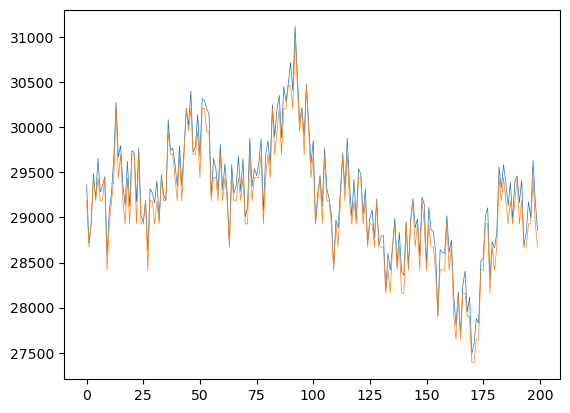

In [23]:
plt.plot(wav[:200], linewidth=0.5)
plt.plot(flac[:200], linewidth=0.5)

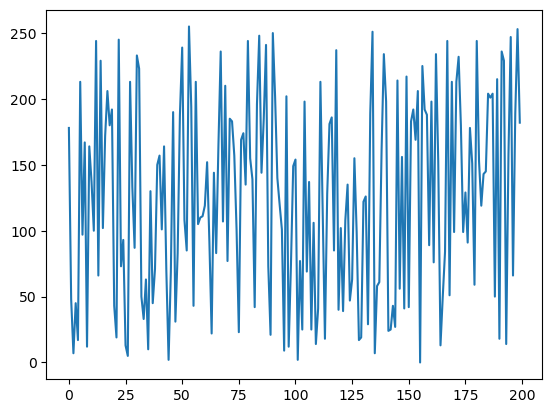

In [24]:
plt.plot(wav[:200] - flac[:200])